# Outcomes


1.   Learned how YOLO algorithm works
2.   Training has not been done on a dataset, as it is difficult to built the YOLO architechture and train it on dataset from scratch. 
3.    Also difficult to perform transfer learning on pretrained weights.

4.    What we have done ==> we have used pretrained weights of YOLO to perfrom mAP metric measurement on dataset created by us, for general object detection task.  



# Preparing the dataset

### Importing necessary libraries

In [ ]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model

# YOLO Architecture

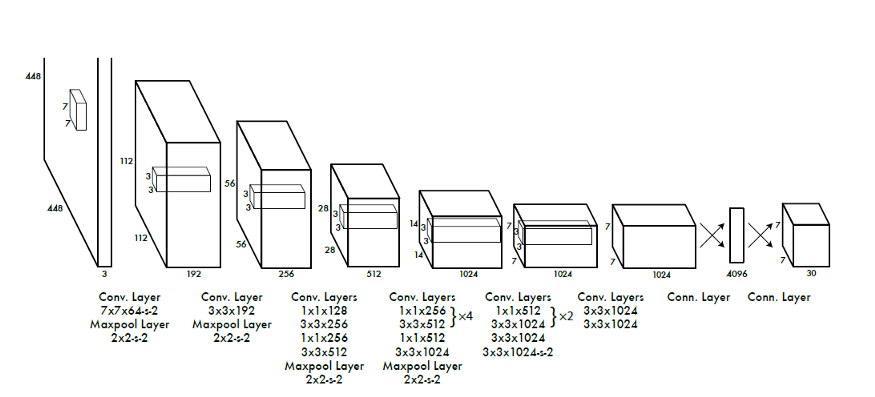

## defining the conv_block used in yolo

In [ ]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
          skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
              conv['kernel'],
              strides=conv['stride'],
              padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
              name='conv_' + str(conv['layer_idx']),
              use_bias=False if conv['bnorm'] else True)(x)
              
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

## YOLO v3 skeleton model

In [ ]:
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

In [ ]:
# This class will parse the weights file from DARKNET fromat to KERAS readable format

class WeightReader:

    def __init__(self, weight_file):
      with open(weight_file, 'rb') as w_f:
          major,	= struct.unpack('i', w_f.read(4))
          minor,	= struct.unpack('i', w_f.read(4))
          revision, = struct.unpack('i', w_f.read(4))
          if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
              w_f.read(8)
          else:
              w_f.read(4)
          transpose = (major > 1000) or (minor > 1000)
          binary = w_f.read()
      self.offset = 0
      self.all_weights = np.frombuffer(binary, dtype='float32')
  
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
  
    def load_weights(self, model):
        for i in range(106):
          try:
            conv_layer = model.get_layer('conv_' + str(i))
            print("loading weights of convolution #" + str(i))
            if i not in [81, 93, 105]:
              norm_layer = model.get_layer('bnorm_' + str(i))
              size = np.prod(norm_layer.get_weights()[0].shape)
              beta  = self.read_bytes(size) # bias
              gamma = self.read_bytes(size) # scale
              mean  = self.read_bytes(size) # mean
              var   = self.read_bytes(size) # variance
              weights = norm_layer.set_weights([gamma, beta, mean, var])
            if len(conv_layer.get_weights()) > 1:
              bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
              kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
              kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
              kernel = kernel.transpose([2,3,1,0])
              conv_layer.set_weights([kernel, bias])
            else:
              kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
              kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
              kernel = kernel.transpose([2,3,1,0])
              conv_layer.set_weights([kernel])
          except ValueError:
            print("no convolution #" + str(i))
  
    def reset(self):
        self.offset = 0

## Defining the model


1.   Define a skeleton keras model
2.   Load the pretrained model weights in darknet format, and create a object of weight reader classs to convert into keras readable format 
3.  Attach the weight file to skeleton keras model
4.  Save the model in keras format



In [ ]:
 
# STEP 1 ==> define a skeleton keras model
model = make_yolov3_model()

# STEP 2 ==> load the pretrained model weights in darknet format, and create a object of weight reader classs to convert into keras readable format 
weight_reader = WeightReader('/content/drive/MyDrive/ml_project/weights/yolov3.weights')

# STEP 3 ==> attach the weight file to skeleton keras model
weight_reader.load_weights(model)

# STEP 4 ==> Save the model in keras format
model.save('/content/drive/MyDrive/ml_project/weights/model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [ ]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:

	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score


In [ ]:
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
# Correction of yolo boxes acc. to image dimension (900*900)->(416*416) 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
# evaluation metric to measure the accuracy of an object on a particular dataset. 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 

# non max suppresion
# class of algorithms to select one entity (e.g. bounding boxes)
# out of many overlapping entities.
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='black')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='red')
	# show the plot
	pyplot.show()

In [ ]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "ambulance",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

## Dealing with data

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ml_project/data/test_data/anot.csv',names=["img_name", "a","b","c","d","e","f","g","h"])

In [ ]:
df.head()

,img_name,a,b,c,d,e,f,g,h
0,c0a105b4fe3a7c55_jpg.rf.337e7abda3a688c88f7c25...,"4,170,42,204,1","54,164,111,226,1","113,132,316,254,1","390,99,416,286,1",NaN,NaN,NaN,NaN
1,b7cc71d4f2108d9c_jpg.rf.2221e609ecb330da5a11e4...,"217,121,338,229,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,08c8b73e0c2e296e_jpg.rf.24496f1095ffd45262fd1f...,"110,90,301,323,1","225,135,368,299,1",NaN,NaN,NaN,NaN,NaN,NaN
3,c89a75a0fa5c2df9_jpg.rf.49b2c884631d30a1ae9c09...,"277,231,371,301,2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,567af04eef831f07_jpg.rf.5fe5255cf67fa988eb15f3...,"0,247,416,416,2",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.shape

(63, 9)

In [ ]:
import math

In [ ]:
classes = []
with open("/content/drive/MyDrive/ml_project/data/test_data/_classes.txt") as f:
    classes = f.readlines()
for i in range(len(classes)):
    classes[i] = classes[i].strip()
    classes[i] = classes[i].lower()

In [ ]:
classes

['ambulance', 'bus', 'car', 'motorcycle', 'truck']

In [ ]:
df[df["img_name"] == "cf165ec304d2b2dc_jpg.rf.26a644096c9f7c14dc93e7d87f9e974c.jpg"]

,img_name,a,b,c,d,e,f,g,h
10,cf165ec304d2b2dc_jpg.rf.26a644096c9f7c14dc93e7...,"0,192,415,385,2",NaN,NaN,NaN,NaN,NaN,NaN,NaN


### preparing the image dictionary for storing testing data

In [ ]:
img_dic = {}
for i in range(df.shape[0]):
    row = df.iloc[i,:]
    # print(row)
    final = []
    for key,val in row.items():
        
        temp = []
        if not (pd.isna(val)):
            arr = val.split(',')
            

            if (len(arr)>1):
                for j in range(0,len(arr)):
                    arr[j] = int(arr[j])
                temp.append(arr[0:4])
                temp.append(arr[-1])
                final.append(temp)
        

    # print(final)
    img_dic[row.img_name] = final 


In [ ]:
len(img_dic.keys())

63

In [ ]:
print(img_dic)

{'c0a105b4fe3a7c55_jpg.rf.337e7abda3a688c88f7c2589b22590db.jpg': [[[4, 170, 42, 204], 1], [[54, 164, 111, 226], 1], [[113, 132, 316, 254], 1], [[390, 99, 416, 286], 1]], 'b7cc71d4f2108d9c_jpg.rf.2221e609ecb330da5a11e451cc51d40b.jpg': [[[217, 121, 338, 229], 0]], '08c8b73e0c2e296e_jpg.rf.24496f1095ffd45262fd1f9d9865e94a.jpg': [[[110, 90, 301, 323], 1], [[225, 135, 368, 299], 1]], 'c89a75a0fa5c2df9_jpg.rf.49b2c884631d30a1ae9c0902ed2b7544.jpg': [[[277, 231, 371, 301], 2]], '567af04eef831f07_jpg.rf.5fe5255cf67fa988eb15f3c0b2c52dd4.jpg': [[[0, 247, 416, 416], 2]], '4ecafc9a0bae8003_jpg.rf.52dc813d101740fa468d507711c3fba0.jpg': [[[23, 72, 398, 348], 4]], 'a3cffcdbff959432_jpg.rf.3670bb831774cd754bf13150ae24ebe3.jpg': [[[46, 36, 395, 316], 4]], 'e4029e591e9568b4_jpg.rf.38b756a0f97631981546c972c9ecd9a1.jpg': [[[39, 100, 415, 397], 2]], '778f80f86cd35fca_jpg.rf.5625682c1153b9a99ebc00149a5456ed.jpg': [[[0, 254, 34, 272], 2], [[58, 249, 72, 264], 2], [[116, 251, 169, 275], 2], [[262, 253, 297, 27

In [ ]:
img_dic['cf165ec304d2b2dc_jpg.rf.26a644096c9f7c14dc93e7d87f9e974c.jpg']

[[[0, 192, 415, 385], 2]]

## Predicting an Example image

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
ambulance 99.93334412574768
car 76.72843337059021


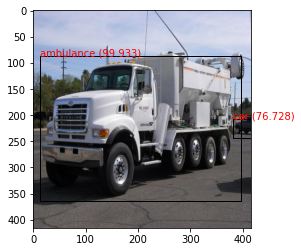

xmin =  12
ymin =  87
xmax =  397
ymax =  364


In [ ]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
 
 
# load yolov3 model
model = load_model('/content/drive/MyDrive/ml_project/weights/model.h5')

# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/content/drive/MyDrive/ml_project/data/4ecafc9a0bae8003_jpg.rf.52dc813d101740fa468d507711c3fba0.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays


print([a.shape for a in yhat])


anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)


print("xmin = ", v_boxes[0].xmin)
print("ymin = ", v_boxes[0].ymin)
print("xmax = ", v_boxes[0].xmax)
print("ymax = ", v_boxes[0].ymax)

In [ ]:
DIR = '/content/drive/MyDrive/ml_project/data/test_data'

## Object detection metric

IoU metric determines how many objects were detected correctly.

*   True Positives [TP]
    *  Number of detections with IoU>0.5

*  False Positives [FP]
    *  Number of detections with IoU<=0.5 or detected more than once



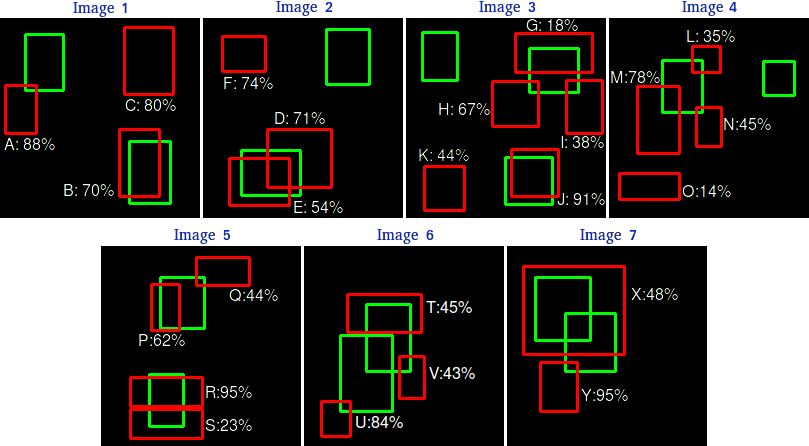

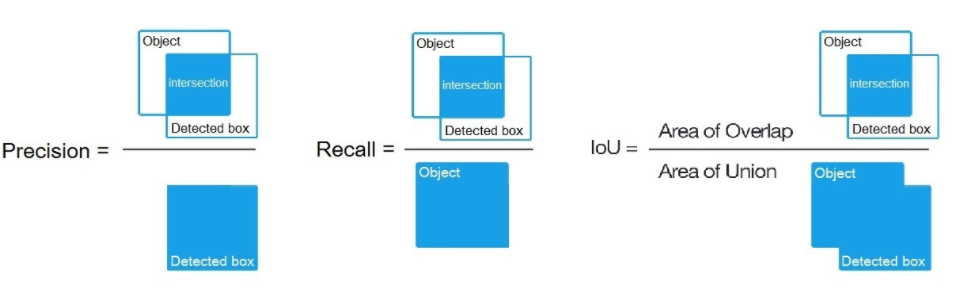

In [ ]:
import os 
count = 0
metric_array = []
for fi in (os.listdir(DIR)):
    if (fi[-3:]=='jpg'):
        path = os.path.join(DIR, fi)
        photo_filename = path

        image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

        yhat = model.predict(image)
        class_threshold = 0.6
        boxes = list()
        for i in range(len(yhat)):

            boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

        correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

        do_nms(boxes, 0.5)
        
        v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
        
        for num,predicted_boxes in enumerate(v_boxes):
            
            boxa = [predicted_boxes.xmin,predicted_boxes.ymin,predicted_boxes.xmax,predicted_boxes.ymax]
            
            try: 
                pred_label = classes.index(v_labels[num])
            except:
                continue
            
            max_iou = -1
            for original_boxes in img_dic[fi]:
                if original_boxes[1] == pred_label:
                    max_iou = max(max_iou,(bb_intersection_over_union(original_boxes[0],boxa)))
            
            # print("max_iou = ",max_iou)
            if (max_iou != -1):
                tp_flag = 0
                if max_iou>=class_threshold:
                    tp_flag = 1
                
                # else:
                #     # for i in range(len(v_boxes)):
                #     #     print(v_labels[i], v_scores[i])
                #     print("predicted class with low iou")
                #     print(v_labels[num], v_scores[num])
                #     # draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
                #     draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

                
                temp = [fi,v_labels[num], v_scores[num], tp_flag, 1-tp_flag]
                # print(temp)
                metric_array.append(temp)
            
            # else:
            #     print("predicted extra class")
            #     print(v_labels[num], v_scores[num])
            #         # draw_boxes(photo_filename, v_boxes, v_labels, v_scores)
            #     draw_boxes(photo_filename, v_boxes, v_labels, v_scores)


        count+=1
        print(fi)
        print(count)

        # if(count==8):

        #     break

        
      

cf165ec304d2b2dc_jpg.rf.26a644096c9f7c14dc93e7d87f9e974c.jpg
1
6d5d24e86c1ff260_jpg.rf.e31fe887e2810466ebef72c75cbf5fe2.jpg
2
259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d42f4c9f859.jpg
3
9876c285fe7bc3a0_jpg.rf.e248d65dab8c80100ed9a29de2e5c3ec.jpg
4
6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f794808d469c.jpg
5
6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4b0c77f1a8a.jpg
6
b3736bcf6bec5308_jpg.rf.d737b611e8e33cc7ed96bf1ef062a4a4.jpg
7
2c21c734126f9f69_jpg.rf.764a9b1b42a1de6b9d281c146ba9efe0.jpg
8
64918de984156adf_jpg.rf.4a7487a204a434104c72363d998ee95a.jpg
9
6f6e6ee0f2f3e68a_jpg.rf.0fed9ec5d683dc4e01b6cd18a5e9b88e.jpg
10
95bf6406c152cf40_jpg.rf.3834c6a0d56619c964611f5667f6e393.jpg
11
86f2efc6efadba44_jpg.rf.b240efe3e5619ccf29336619c90a1405.jpg
12
6e85d4ef31b5eed3_jpg.rf.a393690cdb93c69938f0568574fa006a.jpg
13
4ecafc9a0bae8003_jpg.rf.52dc813d101740fa468d507711c3fba0.jpg
14
c1f88290d602f0e6_jpg.rf.9a040fca9f960271ecff1d2191605196.jpg
15
e4029e591e9568b4_jpg.rf.38b756a0f97631981546c972c

## Calculating mAP

In [ ]:
metric_table = pd.DataFrame(metric_array, columns =['image', 'predictions','confidence', 'true_positive','false_positive'])

In [ ]:
metric_table.head(20)

,image,predictions,confidence,true_positive,false_positive
0,cf165ec304d2b2dc_jpg.rf.26a644096c9f7c14dc93e7...,car,98.794377,1,0
1,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,99.900365,1,0
2,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,98.710632,0,1
3,9876c285fe7bc3a0_jpg.rf.e248d65dab8c80100ed9a2...,ambulance,97.348094,1,0
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0
5,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.777824,1,0
6,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.364454,1,0
7,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.065996,0,1
8,2c21c734126f9f69_jpg.rf.764a9b1b42a1de6b9d281c...,ambulance,98.490477,1,0
9,64918de984156adf_jpg.rf.4a7487a204a434104c7236...,car,99.737716,1,0


In [ ]:
# import pickle

# pickle_out = open("/content/drive/MyDrive/ml_project/weights/metric_table1.pickle","wb")
# pickle.dump(metric_table, pickle_out)
# pickle_out.close()

In [ ]:
import pickle
pickle_in = open("/content/drive/MyDrive/ml_project/weights/metric_table1.pickle","rb")
metric_table1 = pickle.load(pickle_in)

In [ ]:
metric_table1 = metric_table

In [ ]:
metric_table1.sort_values(by=['confidence'],ascending=False,inplace=True)

In [ ]:
metric_table1.head(30)

,image,predictions,confidence,true_positive,false_positive,acc_tp,acc_fp,precision,recall
49,00e481ea1a520175_jpg.rf.49a7562e0ada29cc96e9da...,bus,99.994278,1,0,1,0,1.000000,0.017544
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0,2,0,1.000000,0.035088
21,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.972516,1,0,3,0,1.000000,0.052632
73,479012386aa308fb_jpg.rf.d982f6217082c70dbb8815...,bus,99.955434,1,0,4,0,1.000000,0.070175
67,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.951047,0,1,4,1,0.800000,0.070175
74,e36e433eed49a09d_jpg.rf.6655c319353f478c5e1e6f...,bus,99.938124,1,0,5,1,0.833333,0.087719
69,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.935395,1,0,6,1,0.857143,0.105263
22,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.927485,1,0,7,1,0.875000,0.122807
1,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,99.900365,1,0,8,1,0.888889,0.140351
44,c0a105b4fe3a7c55_jpg.rf.337e7abda3a688c88f7c25...,bus,99.897206,1,0,9,1,0.900000,0.157895


In [ ]:
metric_table1.shape

(79, 5)

In [ ]:

gt_roi = sum(metric_table1["true_positive"])

In [ ]:
gt_roi

57

In [ ]:
tp = 0
fp = 0
acc_tp = []
acc_fp = []
precision = []
recall = []
# for i in range(len(metric_table1)):

for index, row in metric_table1.iterrows():

    if (row["true_positive"] == 1):
        # print(metric_table1.loc[i,"false_positive"])
        tp+=1

    else :
        # print(metric_table1.loc[i,"false_positive"])
        fp+=1

    acc_tp.append(tp)
    acc_fp.append(fp)
    precision.append(tp/(tp+fp))
    recall.append(tp/gt_roi)
# print(len(acc_fp))
metric_table1["acc_tp"] = acc_tp
metric_table1["acc_fp"] = acc_fp
metric_table1["precision"] = precision
metric_table1["recall"] = recall



In [ ]:
metric_table1.head(20)

,image,predictions,confidence,true_positive,false_positive,acc_tp,acc_fp,precision,recall
49,00e481ea1a520175_jpg.rf.49a7562e0ada29cc96e9da...,bus,99.994278,1,0,1,0,1.000000,0.017544
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0,2,0,1.000000,0.035088
21,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.972516,1,0,3,0,1.000000,0.052632
73,479012386aa308fb_jpg.rf.d982f6217082c70dbb8815...,bus,99.955434,1,0,4,0,1.000000,0.070175
67,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.951047,0,1,4,1,0.800000,0.070175
74,e36e433eed49a09d_jpg.rf.6655c319353f478c5e1e6f...,bus,99.938124,1,0,5,1,0.833333,0.087719
69,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.935395,1,0,6,1,0.857143,0.105263
22,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.927485,1,0,7,1,0.875000,0.122807
1,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,99.900365,1,0,8,1,0.888889,0.140351
44,c0a105b4fe3a7c55_jpg.rf.337e7abda3a688c88f7c25...,bus,99.897206,1,0,9,1,0.900000,0.157895


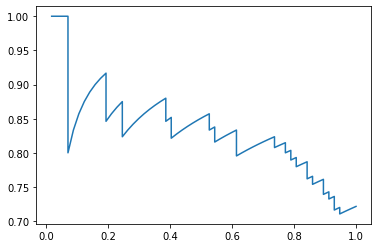

In [ ]:
import matplotlib.pyplot as plt
plt.plot(metric_table1["recall"], metric_table1["precision"])
plt.show()

## 11 point interpolation method to calculate mAP

In [ ]:
recall_divide = np.linspace(0,1,11)

In [ ]:
recall_divide

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
precision_array = list(metric_table1["precision"])
recall_array = list(metric_table1["recall"])

In [ ]:
from bisect import bisect_left
sum_precision = 0
for i in recall_divide:
    # sum_precision += bisect_left(recall_array, i)
    index = (bisect_left(recall_array, i))
    if (index < len(precision_array)):
        sum_precision += precision_array[bisect_left(recall_array, i)]
    

print(sum_precision/11)


0.8348510038337605


# old

In [ ]:
metric_table = pd.DataFrame(metric_array, columns =['image', 'predictions','confidence', 'true_positive','false_positive'])

In [ ]:
metric_table.head(20)

,image,predictions,confidence,true_positive,false_positive
0,cf165ec304d2b2dc_jpg.rf.26a644096c9f7c14dc93e7...,car,98.794389,1,0
1,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,99.900365,1,0
2,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,98.710656,0,1
3,9876c285fe7bc3a0_jpg.rf.e248d65dab8c80100ed9a2...,ambulance,97.348094,1,0
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0
5,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.777854,1,0
6,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.364478,1,0
7,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.066026,0,1
8,2c21c734126f9f69_jpg.rf.764a9b1b42a1de6b9d281c...,ambulance,98.490477,1,0
9,64918de984156adf_jpg.rf.4a7487a204a434104c7236...,car,99.737716,1,0


In [ ]:
# import pickle

# pickle_out = open("/content/drive/MyDrive/ml_project/weights/metric_table.pickle","wb")
# pickle.dump(metric_table, pickle_out)
# pickle_out.close()

In [ ]:
import pickle
pickle_in = open("/content/drive/MyDrive/ml_project/weights/metric_table.pickle","rb")
metric_table1 = pickle.load(pickle_in)

In [ ]:
# del metric_table1

In [ ]:
metric_table1.head(30)

,image,predictions,confidence,true_positive,false_positive
0,cf165ec304d2b2dc_jpg.rf.26a644096c9f7c14dc93e7...,car,98.794389,1,0
1,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,99.900365,1,0
2,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,98.710656,0,1
3,9876c285fe7bc3a0_jpg.rf.e248d65dab8c80100ed9a2...,ambulance,97.348094,1,0
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0
5,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.777854,1,0
6,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.364478,1,0
7,6bc019fc59fce6bc_jpg.rf.e1b7abb4bee867009259c4...,car,92.066026,0,1
8,2c21c734126f9f69_jpg.rf.764a9b1b42a1de6b9d281c...,ambulance,98.490477,1,0
9,64918de984156adf_jpg.rf.4a7487a204a434104c7236...,car,99.737716,1,0


In [ ]:
metric_table1.sort_values(by=['confidence'],ascending=False,inplace=True)

In [ ]:
metric_table1.head()

,image,predictions,confidence,true_positive,false_positive
49,00e481ea1a520175_jpg.rf.49a7562e0ada29cc96e9da...,bus,99.994278,1,0
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0
21,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.972516,1,0
73,479012386aa308fb_jpg.rf.d982f6217082c70dbb8815...,bus,99.955434,1,0
67,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.951047,0,1


In [ ]:
metric_table1.head()

,image,predictions,confidence,true_positive,false_positive
51,00e481ea1a520175_jpg.rf.49a7562e0ada29cc96e9da...,bus,99.994278,1,0
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0
21,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.972516,1,0
72,479012386aa308fb_jpg.rf.d982f6217082c70dbb8815...,bus,99.955434,1,0
66,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.951047,0,1


In [ ]:
metric_table1.shape

(79, 5)

In [ ]:
# gt_roi = 0  # ground truth roi
# for key,val in img_dic.items():
#     gt_roi+=len(val)


gt_roi = sum(metric_table1["true_positive"])

In [ ]:
gt_roi

129

In [ ]:
tp = 0
fp = 0
acc_tp = []
acc_fp = []
precision = []
recall = []
# for i in range(len(metric_table1)):

for index, row in metric_table1.iterrows():

    if (row["true_positive"] == 1):
        # print(metric_table1.loc[i,"false_positive"])
        tp+=1

    else :
        # print(metric_table1.loc[i,"false_positive"])
        fp+=1

    acc_tp.append(tp)
    acc_fp.append(fp)
    precision.append(tp/(tp+fp))
    recall.append(tp/gt_roi)
# print(len(acc_fp))
metric_table1["acc_tp"] = acc_tp
metric_table1["acc_fp"] = acc_fp
metric_table1["precision"] = precision
metric_table1["recall"] = recall



In [ ]:
metric_table1.head(20)

,image,predictions,confidence,true_positive,false_positive,acc_tp,acc_fp,precision,recall
49,00e481ea1a520175_jpg.rf.49a7562e0ada29cc96e9da...,bus,99.994278,1,0,1,0,1.000000,0.017544
4,6a16101bb9217422_jpg.rf.65fdbd6f89aaf2fffbb3f7...,bus,99.986875,1,0,2,0,1.000000,0.035088
21,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.972516,1,0,3,0,1.000000,0.052632
73,479012386aa308fb_jpg.rf.d982f6217082c70dbb8815...,bus,99.955434,1,0,4,0,1.000000,0.070175
67,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.951047,0,1,4,1,0.800000,0.070175
74,e36e433eed49a09d_jpg.rf.6655c319353f478c5e1e6f...,bus,99.938124,1,0,5,1,0.833333,0.087719
69,61b330a7098fba8b_jpg.rf.a286637617b379997582be...,car,99.935395,1,0,6,1,0.857143,0.105263
22,f00ec0093e986e99_jpg.rf.879f58747542c9772ae57a...,car,99.927485,1,0,7,1,0.875000,0.122807
1,259ff749ac781352_jpg.rf.0f5cde8bd9706b401e535d...,car,99.900365,1,0,8,1,0.888889,0.140351
44,c0a105b4fe3a7c55_jpg.rf.337e7abda3a688c88f7c25...,bus,99.897206,1,0,9,1,0.900000,0.157895


57

In [ ]:
metric_table1.loc[74,:]

image             958efc095c686ef6_jpg.rf.63d82f9a4a84a3947649e9...
predictions                                                     car
confidence                                                  60.0282
true_positive                                                     1
false_positive                                                    0
acc_tp                                                           58
acc_fp                                                           22
precision                                                     0.725
recall                                                     0.449612
Name: 74, dtype: object

In [ ]:
import matplotlib.pyplot as plt


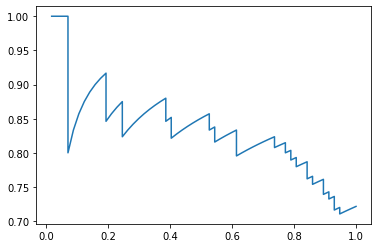

In [ ]:
plt.plot(metric_table1["recall"], metric_table1["precision"])
plt.show()

11 point interpolation

In [ ]:
recall_divide = np.linspace(0,1,11)

In [ ]:
recall_divide

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
precision_array = list(metric_table1["precision"])
recall_array = list(metric_table1["recall"])

In [ ]:
from bisect import bisect_left
sum_precision = 0
for i in recall_divide:
    # sum_precision += bisect_left(recall_array, i)
    index = (bisect_left(recall_array, i))
    if (index < len(precision_array)):
        sum_precision += precision_array[bisect_left(recall_array, i)]
    

print(sum_precision/11)


0.8348510038337605
